### Library import

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

from string import punctuation
from nltk.corpus import stopwords
from collections import defaultdict, Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

### Data import

In [103]:
csv_files = glob.glob("data/TelevisionNews/*.csv")
df = []
for file in csv_files:
    csv = pd.read_csv(file, header=None, names=['URL', 'MatchDateTime', 'Station', 'Show', 'IAShowID','IAPreviewThumb','Snippet'])
    csv = csv.iloc[1:] #drow first row containing column names 
    df.append(csv)
df = pd.concat(df)

In [104]:
df= df.drop(['URL','Show','IAShowID', 'IAPreviewThumb'], axis=1)

In [106]:
# check for duplicates
duplicates = df.duplicated(subset=['Snippet']).sum()
print(f"There are {duplicates} duplicated records.")

# remove duplicates
df = df.drop_duplicates(subset=['Snippet'], keep='first')
print(f"Number of records after dropping duplicates: {len(df)}")

There are 3995 duplicated records.
Number of records after dropping duplicates: 90863


### Preprocessing

In [107]:
# define functions

punctuation = set(punctuation) # speeds up comparison
sw = stopwords.words('english')

def remove_stopwords(tokens) :
    return [token for token in tokens if token not in sw]
    return(tokens)

def remove_punctuation(text) :
    return "".join(ch for ch in text if ch not in punctuation)

def tokenize(text) :
    tokens = text.split()
    return(tokens)

The following phrases were used to isolate news snippets for climate change discussions, and therefore commonly present in the data: "climate change", "global warming", "climate crisis", "greenhouse gas", "greenhouse gases", "carbon tax".

We will create a separate column without these phrases for further analysis. 

In [108]:
# remove bi-gram phrases in all snippets 
def remove_bigram_phrases(text, phrases_to_remove):
     for phrase in phrases_to_remove:
         text = text.replace(phrase, '')
     return text

# Climate bi-gram phrases
climate_grams = ["climate change", "global warming", "climate crisis", "greenhouse gas", "greenhouse gases", "carbon tax"]

# Apply the custom function to each row
df['snippet_no_climate'] = df['Snippet'].map(lambda x: remove_bigram_phrases(x, climate_grams))

df.head(10)

,MatchDateTime,Station,Snippet,snippet_no_climate
1,3/15/2011 15:11:06,FOXNEWS,forward. greg: i suppose worth pointing out th...,forward. greg: i suppose worth pointing out th...
2,3/31/2011 13:16:41,FOXNEWS,threaten a government shutdown. that's what's ...,threaten a government shutdown. that's what's ...
3,3/30/2011 17:29:04,FOXNEWS,"and less likely. in any case, president obama ...","and less likely. in any case, president obama ..."
4,3/14/2011 22:09:55,FOXNEWS,environmental catastrophe in another part of t...,environmental catastrophe in another part of t...
6,3/21/2011 19:03:10,FOXNEWS,"century: energy. to have clean, safe, renewabl...","century: energy. to have clean, safe, renewabl..."
7,3/13/2011 17:08:16,FOXNEWS,as they have tried to find alternatives to gre...,as they have tried to find alternatives to em...
8,3/15/2011 11:25:15,FOXNEWS,in a political purgatory for 30 years. only th...,in a political purgatory for 30 years. only th...
9,3/13/2011 12:15:27,FOXNEWS,"no carbon greenhouse gas emissions. of course,...","no carbon emissions. of course, now, we're se..."
10,3/21/2011 18:27:27,FOXNEWS,"modern society, fight against drug trafficking...","modern society, fight against drug trafficking..."
11,3/12/2011 15:55:33,FOXNEWS,"perceive, that thought about global warming, t...","perceive, that thought about , the warming of ..."


In [109]:
# change dtypes 
df.columns = df.columns.str.lower()
df['matchdatetime'] = pd.to_datetime(df['matchdatetime'])
df['station'] = df['station'].astype('string')
df['snippet'] = df['snippet'].astype('string')
df['snippet_no_climate'] = df['snippet_no_climate'].astype('string')

df.dtypes

matchdatetime         datetime64[ns]
station               string[python]
snippet               string[python]
snippet_no_climate    string[python]
dtype: object

In [110]:
# data preprocessing
df['tokens'] = df['snippet'].str.lower()
df['tokens'] = df['tokens'].apply(remove_punctuation)
df['tokens'] = tokenize(df['tokens'].str)
df['tokens'] = df['tokens'].apply(remove_stopwords)

df['tokens_no_climate'] = df['snippet_no_climate'].str.lower()
df['tokens_no_climate'] = df['tokens_no_climate'].apply(remove_punctuation)
df['tokens_no_climate'] = tokenize(df['tokens_no_climate'].str)
df['tokens_no_climate'] = df['tokens_no_climate'].apply(remove_stopwords)

# reorder columns
df = df[['matchdatetime', 'station', 'snippet', 'tokens', 'snippet_no_climate', 'tokens_no_climate']]
df

,matchdatetime,station,snippet,tokens,snippet_no_climate,tokens_no_climate
1,2011-03-15 15:11:06,FOXNEWS,forward. greg: i suppose worth pointing out th...,"[forward, greg, suppose, worth, pointing, gene...",forward. greg: i suppose worth pointing out th...,"[forward, greg, suppose, worth, pointing, gene..."
2,2011-03-31 13:16:41,FOXNEWS,threaten a government shutdown. that's what's ...,"[threaten, government, shutdown, thats, whats,...",threaten a government shutdown. that's what's ...,"[threaten, government, shutdown, thats, whats,..."
3,2011-03-30 17:29:04,FOXNEWS,"and less likely. in any case, president obama ...","[less, likely, case, president, obama, would, ...","and less likely. in any case, president obama ...","[less, likely, case, president, obama, would, ..."
4,2011-03-14 22:09:55,FOXNEWS,environmental catastrophe in another part of t...,"[environmental, catastrophe, another, part, wo...",environmental catastrophe in another part of t...,"[environmental, catastrophe, another, part, wo..."
6,2011-03-21 19:03:10,FOXNEWS,"century: energy. to have clean, safe, renewabl...","[century, energy, clean, safe, renewable, ener...","century: energy. to have clean, safe, renewabl...","[century, energy, clean, safe, renewable, ener..."
...,...,...,...,...,...,...
32,2012-02-24 14:24:07,CNN,will galvanize them to do stuff and understand...,"[galvanize, stuff, understand, climate, change...",will galvanize them to do stuff and understand...,"[galvanize, stuff, understand, kyra, scuba, di..."
33,2012-02-23 09:20:57,CNN,"ballot. still to come on wbt, china, the u.s.,...","[ballot, still, come, wbt, china, us, russia, ...","ballot. still to come on wbt, china, the u.s.,...","[ballot, still, come, wbt, china, us, russia, ..."
34,2012-02-10 15:57:13,CNN,or newt gingrich all that much at all. he was ...,"[newt, gingrich, much, really, trying, say, fo...",or newt gingrich all that much at all. he was ...,"[newt, gingrich, much, really, trying, say, fo..."
35,2012-02-29 13:56:13,CNN,endless primary with hillary clinton. there we...,"[endless, primary, hillary, clinton, policy, i...",endless primary with hillary clinton. there we...,"[endless, primary, hillary, clinton, policy, i..."


In [113]:
# Store as csv
df.to_csv('data/news_cleaned.csv', index=False)

### Descriptive statistics

In [114]:
def descriptive_stats(tokens, verbose=True) :
    num_tokens=len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(token) for token in tokens)

    if verbose :
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        # print the five most common tokens
        counter = Counter(tokens)
        top_10_tokens = counter.most_common(10)
        print("\nTop 10 most common tokens:")
        for token, count in top_10_tokens:
            print(f"{token}: {count} occurrences")

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

def count_words(df, column, preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

def wordcloud(word_freq, title=None, max_words=200, stopwords=sw):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [115]:
print("Number of news snippets:", len(df))
print("News stations:", df['station'].unique())
print("\nCount of snippets for each news station:\n",df['station'].value_counts())

Number of news snippets: 90863
News stations: <StringArray>
['FOXNEWS', 'MSNBC', 'BBCNEWS', 'CNN']
Length: 4, dtype: string

Count of snippets for each news station:
 station
MSNBC      25593
FOXNEWS    23837
BBCNEWS    22693
CNN        18740
Name: count, dtype: Int64


In [116]:
combined_tokens=[token for sublist in df['tokens'] for token in sublist]
print('Descriptive Statistics (Keep Climate Phrases)\n')
descriptive_stats(combined_tokens)

Descriptive Statistics (Keep Climate Phrases)

There are 2020510 tokens in the data.
There are 46276 unique tokens in the data.
There are 12336107 characters in the data.
The lexical diversity is 0.023 in the data.

Top 10 most common tokens:
climate: 81945 occurrences
change: 74787 occurrences
global: 22962 occurrences
warming: 19892 occurrences
president: 13232 occurrences
people: 11953 occurrences
going: 11192 occurrences
think: 11146 occurrences
one: 9943 occurrences
us: 9153 occurrences


[2020510, 46276, 0.022903128418072665, 12336107]

Wordcloud (Keep Climate Phrases)


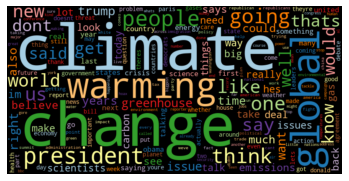

In [117]:
words = count_words(df, 'tokens')
print('Wordcloud (Keep Climate Phrases)')
wordcloud(words['freq'])

In [118]:
combined_tokens=[token for sublist in df['tokens_no_climate'] for token in sublist]
print('Descriptive Statistics (Removed Climate Phrases)\n')
descriptive_stats(combined_tokens)

Descriptive Statistics (Removed Climate Phrases)

There are 1824455 tokens in the data.
There are 46236 unique tokens in the data.
There are 11049421 characters in the data.
The lexical diversity is 0.025 in the data.

Top 10 most common tokens:
president: 13232 occurrences
people: 11953 occurrences
going: 11192 occurrences
think: 11146 occurrences
one: 9943 occurrences
us: 9153 occurrences
like: 8760 occurrences
say: 8635 occurrences
new: 8080 occurrences
world: 8075 occurrences


[1824455, 46236, 0.02534236251373698, 11049421]

Wordcloud (Removed Climate Phrases)


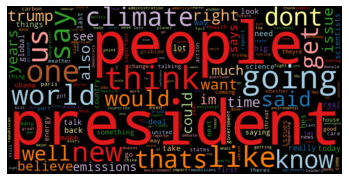

In [119]:
words = count_words(df, 'tokens_no_climate')
print('Wordcloud (Removed Climate Phrases)')
wordcloud(words['freq'])

### Volumn 

In [120]:
df['station'].value_counts()

station
MSNBC      25593
FOXNEWS    23837
BBCNEWS    22693
CNN        18740
Name: count, dtype: Int64

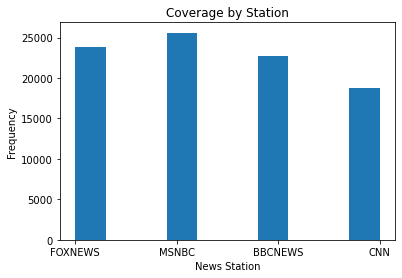

In [121]:
plt.hist(df['station'])
plt.title('Coverage by Station')
plt.xlabel('News Station')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 0, 'Time')

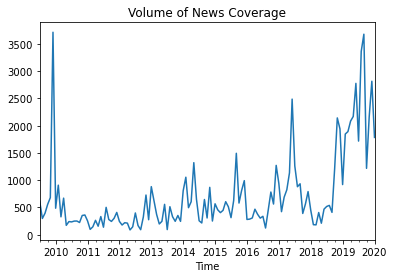

In [122]:
date_year= df['matchdatetime'].dt.to_period('M')
date_year.value_counts().sort_index().plot()
plt.title('Volume of News Coverage')
plt.xlabel('Time')

Overall, there is a gradual increase in overall coverage.

In 2010, NASA's Goddard Institute for Space Studies (GISS) reports global surface temperatures to be at an all time high (https://climate.nasa.gov/news/467/nasa-research-finds-2010-tied-for-warmest-year-on-record/#:~:text=In%202010%2C%20global%20temperatures%20continued,the%20warmest%20decade%20on%20record.)

Notes: The Internet Archive's feed for FOXNEWS, MSNB, and CNN started in July 2009 and BBCNEWS in January 2017. This could partially explain the spike in coverage beginning in 2017. 

<Figure size 864x576 with 0 Axes>

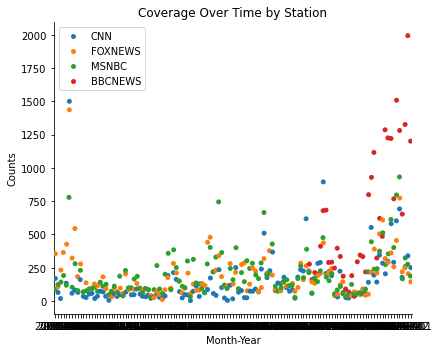

In [123]:
# Extract month and year
df['month_year'] = df['matchdatetime'].dt.to_period('M')

# Group the data by 'station' and 'month_year' and count occurrences
station_monthly_occurrences = df.groupby(['month_year','station' ]).size().reset_index(name='counts')

# Plot
plt.figure(figsize=(12, 8))
plot = sns.catplot(data=station_monthly_occurrences, x='month_year', y='counts', hue='station', marker='o')
plot._legend.remove()

# Set labels and title
plt.title('Coverage Over Time by Station')
plt.xlabel('Month-Year')
plt.ylabel('Counts')

# Show plot
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 864x576 with 0 Axes>

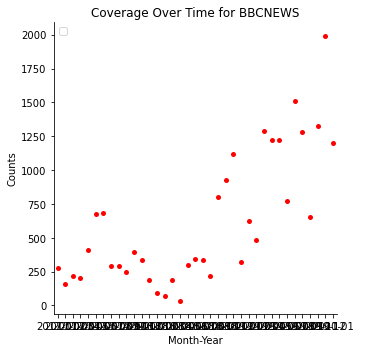

In [124]:
# Plot
plt.figure(figsize=(12, 8))
plot = sns.catplot(data=station_monthly_occurrences[station_monthly_occurrences['station']=='BBCNEWS'], x='month_year', y='counts', color='red', marker='o')

# Set labels and title
plt.title('Coverage Over Time for BBCNEWS')
plt.xlabel('Month-Year')
plt.ylabel('Counts')

# Show plot
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()


<Figure size 864x576 with 0 Axes>

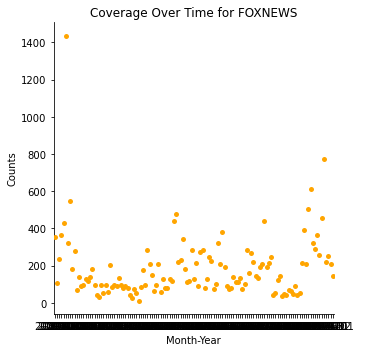

In [125]:
# Plot
plt.figure(figsize=(12, 8))
plot = sns.catplot(data=station_monthly_occurrences[station_monthly_occurrences['station']=='FOXNEWS'], x='month_year', y='counts', color='orange', marker='o')

# Set labels and title
plt.title('Coverage Over Time for FOXNEWS')
plt.xlabel('Month-Year')
plt.ylabel('Counts')

# Show plot
plt.tight_layout()
plt.show()


<Figure size 864x576 with 0 Axes>

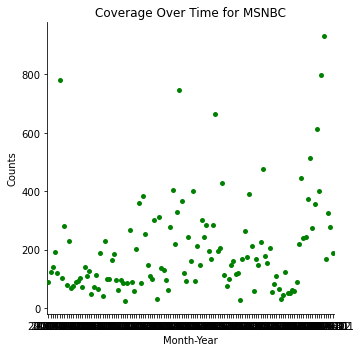

In [126]:
# Plot
plt.figure(figsize=(12, 8))
plot = sns.catplot(data=station_monthly_occurrences[station_monthly_occurrences['station']=='MSNBC'], x='month_year', y='counts', color='green', marker='o')
plot._legend.remove()

# Set labels and title
plt.title('Coverage Over Time for MSNBC')
plt.xlabel('Month-Year')
plt.ylabel('Counts')

# Show plot
plt.tight_layout()
plt.show()


In [127]:
station_monthly_occurrences[station_monthly_occurrences['month_year']=='2019-12']

,month_year,station,counts
409,2019-12,BBCNEWS,1993
410,2019-12,CNN,340
411,2019-12,FOXNEWS,206
412,2019-12,MSNBC,277
